In [1]:
import timm
from fastai.vision.all import *

dk_dir = Path("dk_bugs_preproc")
fin_dir = Path("finland_bugs")
ept_dir = Path("ept_bugs_preproc")

model_dir = Path("models")

images_size = 300

/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(len(get_image_files(dk_dir)))
print(len(get_image_files(fin_dir)))
print(len(get_image_files(ept_dir)))

2526
15074
4784


In [3]:
#https://www.kaggle.com/code/dienhoa/healthy-lung-classification-spectrogram-fast-ai/notebook

In [3]:
targets = [parent_label(i) for i in get_image_files(dk_dir)]
count = Counter(targets)
wgts = [1/count[i] for i in targets]

dk_db = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items = get_image_files,
                  splitter = TrainTestSplitter(stratify=targets),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=2, size=images_size, min_scale=0.5, flip_vert=True),
                  get_y = parent_label)
dk_dl = dk_db.weighted_dataloaders(dk_dir, wgts=wgts, bs=32)

In [5]:
dk_n = len(dk_dl.vocab)

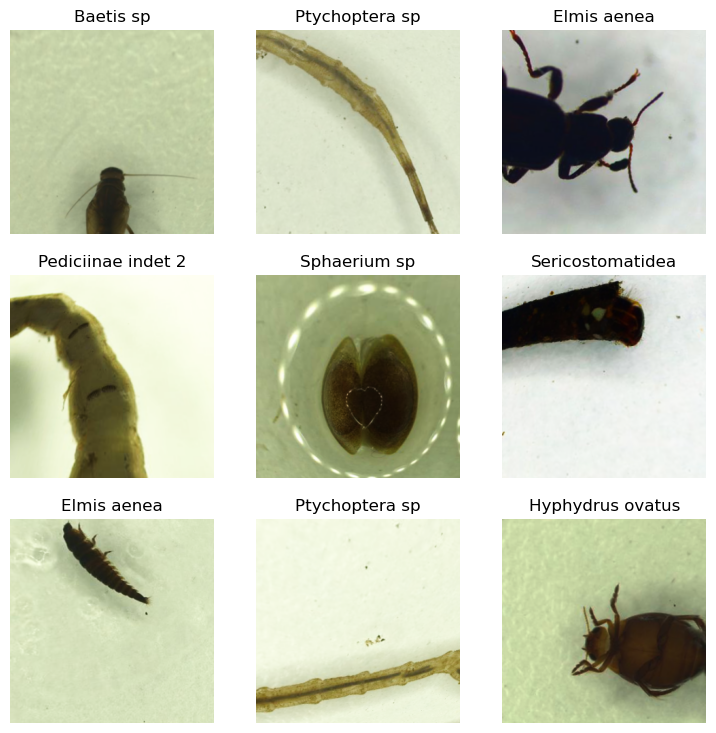

In [9]:
dk_dl.show_batch()

In [5]:
x, y = dk_dl.one_batch()

In [13]:
x[0]

TensorImage(0.5965, device='cuda:0')

In [4]:
#train learner using ept dataset
learn = vision_learner(dk_dl, 
                       "efficientnet_b3",
                       pretrained=True,
                       normalize=True,
                       #cbs=[MixUp()],
                       loss_func=LabelSmoothingCrossEntropy(),
                       metrics=[accuracy, top_k_accuracy]).to_fp16()

In [5]:
learn.fine_tune(epochs=20, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.409456,1.688537,0.650198,0.916996,00:15
1,2.150751,1.332058,0.839921,0.972332,00:14
2,1.748855,1.417928,0.790514,0.956522,00:15


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.460904,1.267466,0.837945,0.968379,00:18
1,1.376356,1.226682,0.857708,0.970356,00:18
2,1.343325,1.127976,0.899209,0.978261,00:18
3,1.312627,1.132872,0.877470,0.980237,00:18
4,1.263354,1.144158,0.871542,0.984190,00:18
5,1.199419,1.011112,0.920949,0.992095,00:18
6,1.188033,1.026532,0.918972,0.984190,00:18
7,1.140233,1.025471,0.907115,0.992095,00:18
8,1.097429,0.983460,0.920949,0.990119,00:18
9,1.072470,0.969223,0.936759,0.988142,00:18


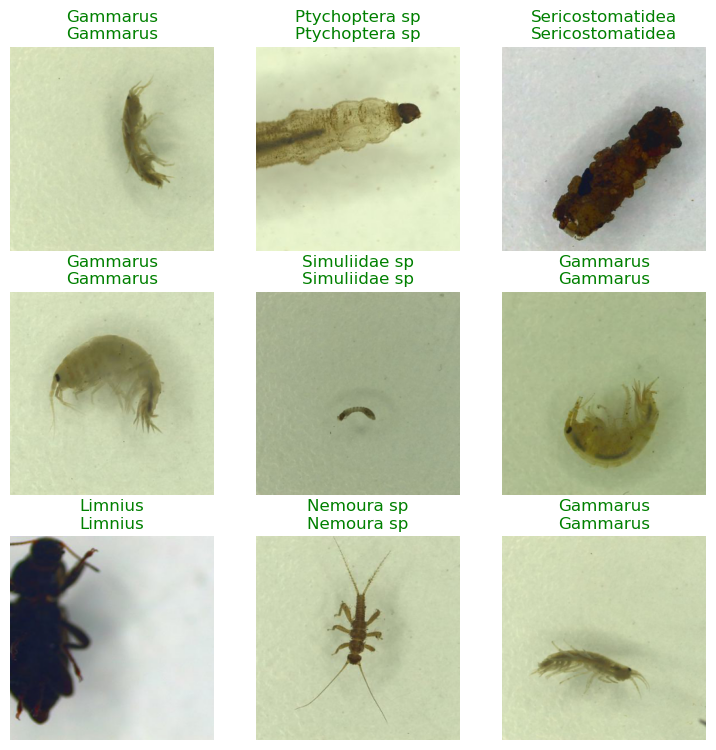

In [6]:
learn.show_results()

In [7]:
#save model
learn.path = model_dir
learn.export("effnet_b3.export")

In [31]:
vocab = learn.dls.vocab

with open(model_dir/"dk_vocab.txt", 'w') as f:
    f.write('\n'.join(vocab))

In [8]:
from torchvision import transforms

#define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

#define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

#assemble the final model
final_model = nn.Sequential(normalization_layer, torch_model, softmax_layer)

In [9]:
# generate model input
dummy_input = torch.randn(1, 3, images_size, images_size, requires_grad=True)

onnx_model_path = model_dir/"effnet_b3.onnx"


In [10]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html
#model export into ONNX format
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

In [37]:
#test fastai preds vs opencv

In [12]:
import cv2

tmp="dk_bugs_preproc/Erpobdella octoculato/Erpobdella octoculato002.jpg"

model_vocab = []
with open("models/dk_vocab.txt", 'r') as f:
    for i in f:
        x = i[:-1]
        model_vocab.append(x)

In [13]:
#load fastai model
learn = load_learner(model_dir/"effnet_b3.export")

In [14]:
pred, pred_idx, probs = learn.predict(tmp)
print(pred)
print(pred_idx)
print(probs)

Erpobdella octoculato
TensorBase(6)
TensorBase([3.7876e-03, 1.4055e-03, 1.0654e-03, 2.7079e-03, 1.5490e-03,
            1.4937e-03, 9.6794e-01, 7.3084e-04, 5.5927e-04, 5.0436e-04,
            4.8122e-04, 9.2180e-04, 3.6048e-04, 8.2964e-04, 1.6066e-03,
            3.4049e-04, 4.5307e-04, 3.0887e-03, 7.1304e-04, 7.5050e-04,
            1.4992e-03, 5.4788e-04, 4.5340e-04, 4.4914e-03, 5.9152e-04,
            1.9840e-04, 9.3153e-04])


In [15]:
img = cv2.imread(tmp)

In [16]:
model_path = "models/effnet_b3.onnx"
model = cv2.dnn.readNetFromONNX(model_path)

In [18]:
model_input = cv2.dnn.blobFromImage(
                image = img,
                scalefactor = 1.0/255.0,
                size = (images_size, images_size),
                swapRB=True,
                crop=True)  

In [19]:
model.setInput(model_input)
out = model.forward().squeeze()
idx_pred = np.argmax(out)
class_pred = model_vocab[idx_pred]

In [20]:
list(out)

[0.0050482512,
 0.0017537953,
 0.00058457366,
 0.0044957036,
 0.0013976505,
 0.00153644,
 0.9664932,
 0.00068233715,
 0.00044065437,
 0.00039609906,
 0.0010620565,
 0.000716919,
 0.00043023488,
 0.00074653537,
 0.0019502399,
 0.0004926067,
 0.00051821553,
 0.0019159592,
 0.0006240619,
 0.00077295554,
 0.0011219404,
 0.00042835445,
 0.0005313849,
 0.0036684624,
 0.00096661056,
 0.00019896541,
 0.0010257751]

In [21]:
list(probs)

[TensorBase(0.0038),
 TensorBase(0.0014),
 TensorBase(0.0011),
 TensorBase(0.0027),
 TensorBase(0.0015),
 TensorBase(0.0015),
 TensorBase(0.9679),
 TensorBase(0.0007),
 TensorBase(0.0006),
 TensorBase(0.0005),
 TensorBase(0.0005),
 TensorBase(0.0009),
 TensorBase(0.0004),
 TensorBase(0.0008),
 TensorBase(0.0016),
 TensorBase(0.0003),
 TensorBase(0.0005),
 TensorBase(0.0031),
 TensorBase(0.0007),
 TensorBase(0.0008),
 TensorBase(0.0015),
 TensorBase(0.0005),
 TensorBase(0.0005),
 TensorBase(0.0045),
 TensorBase(0.0006),
 TensorBase(0.0002),
 TensorBase(0.0009)]